In [107]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from skimage import io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle


In [246]:

# define the path to the input images
input_path = r"C:\Users\user\Documents\GitHub\Hand Gesture\Hand-Gesture\input"

# define the path to the output preprocessed images
output_path = r"C:\Users\user\Documents\GitHub\Hand Gesture\Hand-Gesture\output"

# define the target size of the preprocessed images
target_size = (64, 64)

# define the preprocessing functions


def convert_to_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.convertScaleAbs(gray)
    return gray


def apply_gaussian_blur(img):
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    return blurred


def apply_threshold(img):
    _, thresh = cv2.threshold(
        img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return thresh


def find_contours(img):
    contours, hierarchy = cv2.findContours(
        img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours, hierarchy


def find_largest_contour(contours):
    max_contour = max(contours, key=cv2.contourArea)
    return max_contour


def create_mask(img, contour):
    mask = cv2.drawContours(np.zeros_like(
        img), [contour], 0, (255, 255, 255), -1)
    return mask


def apply_mask(img, mask):
    masked_image = cv2.bitwise_and(img, img, mask=mask)
    return masked_image


def resize_image(img, size):
    resized = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return resized


def normalize_image(img):
    normalized = img.astype("float32") / 255.0
    return normalized


def get_hog_features(img):
    win_size = (64, 64)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(win_size, block_size,
                            block_stride, cell_size, nbins)
    hog_feats = hog.compute(img)
    return hog_feats


def get_sift_features(img):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return descriptors

def split_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def svm_model(X_train, y_train, X_test):
    clf = svm.SVC(kernel='rbf')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
   
    # filename = 'SVC.sav'
    # pickle.dump(clf, open(filename, 'wb'))
    
    return y_pred


def random_forest_model(X_train, y_train, X_test):
    rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    
    # filename = 'RFC.sav'
    # pickle.dump(clf, open(filename, 'wb'))
    
    return y_pred


def calc_accuracy(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [239]:
#preprocessing phase        
def preprocess(img_path):
    img = io.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred = apply_gaussian_blur(gray)
    blurred = np.uint8(blurred)
    thresh = apply_threshold(blurred)
    contours, hierarchy = find_contours(thresh)
    max_contour = find_largest_contour(contours)
    mask = create_mask(gray, max_contour)
    masked_image = apply_mask(img, mask)
    resized = resize_image(masked_image, target_size)
    normalized = normalize_image(resized)
    
    return normalized

def preprocess_2(img_path):
    img = io.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    equ = cv2.equalizeHist(gray)
    
    processed = equ
    
    if processed.shape[2] == 3:
       processed = processed[0] 
    return processed

def preprocess_3(img_path):
    img = io.imread(img_path)

    #1 Image Rescaling
    img = cv2.resize(img, (320, 180))

    #2 Image Enhancement
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.equalizeHist(img_gray)

    #3 Background Subtraction
    fgbg = cv2.createBackgroundSubtractorMOG2()
    fgmask = fgbg.apply(img_gray)
    img_gray = cv2.bitwise_and(img_gray, img_gray, mask=fgmask)

    #4 Skin Color Detection
    # lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    # upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    # hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # mask = cv2.inRange(hsv_img, lower_skin, upper_skin)
    # img_gray = cv2.bitwise_and(img_gray, img_gray, mask=mask)

    # #5 Noise Reduction
    # Blur
    img_gray = cv2.medianBlur(img_gray, 3)

    # #6 Image Segmentation
    # ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # img_gray = cv2.bitwise_and(img_gray, img_gray, mask=thresh)
    
    return img_gray

preprocessed = preprocess_3('dataset/5/5_men (26).jpg')
cv2.imshow('Processed Image', preprocessed)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [240]:
# set the parameters for HoG
orientations = 9
pixels_per_cell = (50, 50)
cells_per_block = (3, 3)
visualize = False
transform_sqrt = False
normalize = True
load_features_from_file=False
save_feature=True
all_feats = []
all_imgs = []

image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

if load_features_from_file == False:
    for root, dirs, files in os.walk('dataset'):
        j = 0
        for dir in dirs:
            j+=1
            i = 0
            print(os.path.join(root, dir))
            for file in os.listdir(os.path.join(root, dir)):
                i+=1
                if any(file.lower().endswith(extension) for extension in image_extensions):
                    img_path = os.path.join(root, dir, file)
                    print(j, ' ', i)
                    # print(img_path)
                    label = np.array([int(dir)])
                    
                    processed = preprocess_3(img_path)
                    # processed = io.imread(img_path, as_gray=True)
                    # print(processed.shape)

                    #calculate the HoG features for the image
                    hog_result = hog(
                        processed,
                        orientations = orientations,
                        pixels_per_cell = pixels_per_cell,
                        cells_per_block = cells_per_block,
                        visualize = visualize,
                        transform_sqrt = transform_sqrt,
                        block_norm = 'L2-Hys',
                        feature_vector = True
                    )

                    # unpack the HoG result into features and hog_image variables if necessary
                    if visualize:
                        features, hog_image = hog_result
                    else:
                        features = hog_result
                    
                    feats = np.concatenate((label, features.ravel()))
                    all_feats.append(feats)
           
else:
    all_feats = np.loadtxt("hog_features.txt")

features_array = np.array(all_feats, dtype=object)

if(save_feature):
    np.savetxt("hog_features.txt", features_array)


print("Feature Extraction Finished")

dataset\0
1   1
1   2
1   3
1   4
1   5
1   6
1   7
1   8
1   9
1   10
1   11
1   12
1   13
1   14
1   15
1   16
1   17
1   18
1   19
1   20
1   21
1   22
1   23
1   24
1   25
1   26
1   27
1   28
1   29
1   30
1   31
1   32
1   33
1   34
1   35
1   36
1   37
1   38
1   39
1   40
1   41
1   42
1   43
1   44
1   45
1   46
1   47
1   48
1   49
1   50
1   51
1   52
1   53
1   54
1   55
1   56
1   57
1   58
1   59
1   60
1   61
1   62
1   63
1   64
1   65
1   66
1   67
1   68
1   69
1   70
1   71
1   72
1   73
1   74
1   75
1   76
1   77
1   78
1   79
1   80
1   81
1   82
1   83
1   84
1   85
1   86
1   87
1   88
1   89
1   90
1   91
1   92
1   93
1   94
1   95
1   96
1   97
1   98
1   99
1   100
1   101
1   102
1   103
1   104
1   105
1   106
1   107
1   108
1   109
1   110
1   111
1   112
1   113
1   114
1   115
1   116
1   117
1   118
1   119
1   120
1   121
1   122
1   123
1   124
1   125
1   126
1   127
1   128
1   129
1   130
1   131
1   132
1   133
1   134
1   135
1   136
1   137
1 

In [241]:
print(features_array.shape)

(1821, 325)


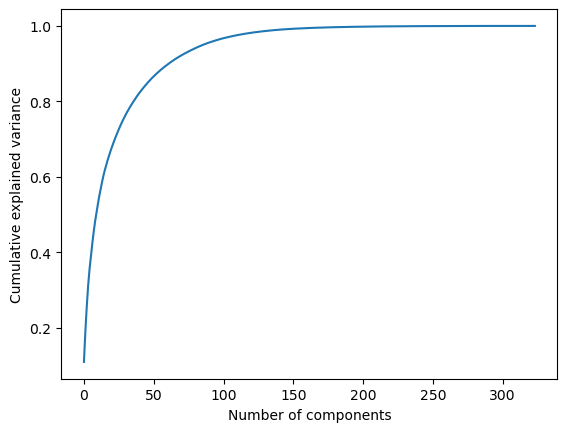

In [247]:
# get the optimal number of components to use

pca = PCA().fit(features_array[:, 1:])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [248]:
features_array = np.array(all_feats, dtype=object)

In [281]:
# apply PCA
pca = PCA(n_components=85)
Y = np.array(features_array[:, 0]).astype('int32')
X = pca.fit_transform(features_array[:, 1:])

# X = features_array[:, 1:]

# splitting data into train and test
X_train, X_test, y_train, y_test = split_dataset(X, Y)

print(X_train.shape)
print(y_train.shape)

# apply SVM
y_pred = svm_model(X_train, y_train, X_test)

# apply RFC
# rfc = RandomForestClassifier(n_estimators=1000, max_depth=100, random_state=0)
# y_pred = rfc.fit(X_train, y_train).predict(X_test)


print("SVM Finished")

(1456, 85)
(1456,)
SVM Finished


In [282]:
# calc accuracy
accuracy = calc_accuracy(y_test, y_pred)
print(accuracy)


0.7616438356164383
